In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "XXXXXXXX" # username from the json file
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXX" # Provide your key from the json file
!XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX # api copied from kaggle

100% 741M/745M [00:06<00:00, 116MB/s]
100% 745M/745M [00:06<00:00, 117MB/s]


In [2]:
# Upload data and extract the contents
from zipfile import ZipFile

file_name = "/content/covid19-radiography-database.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
# Data preprocessing
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2
#Model
import keras
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 
#Model Analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from numpy.random import seed
seed(0)
import tensorflow
tensorflow.random.set_seed(0)

In [5]:
path = '/content/COVID-19_Radiography_Dataset'

diag_code_dict = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3}

diag_title_dict = {
    'COVID': 'Covid-19',
    'Lung_Opacity': 'Lung Opacity',
    'Normal': 'Normal',
    'Viral Pneumonia': 'Viral Pneumonia'}

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

covidData = pd.DataFrame.from_dict(imageid_path_dict, orient = 'index').reset_index()
covidData.columns = ['image_id','path']
classes = covidData.image_id.str.split('-').str[0]
covidData['diag'] = classes
covidData['target'] = covidData['diag'].map(diag_code_dict.get) 
covidData['Class'] = covidData['diag'].map(diag_title_dict.get) 

In [6]:
samples,features = covidData.shape
duplicated = covidData.duplicated().sum()
null_values = covidData.isnull().sum().sum()

print('Basic EDA')
print('Number of samples: %d'%(samples))
print('Number of duplicated values: %d'%(duplicated))
print('Number of Null samples: %d' % (null_values))

Basic EDA
Number of samples: 21165
Number of duplicated values: 0
Number of Null samples: 0


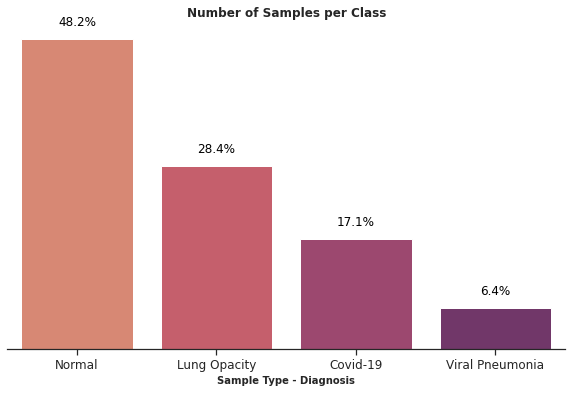

In [7]:
#Samples per class
plt.figure(figsize=(10,6))
sns.set(style="ticks", font_scale = 1)
ax = sns.countplot(data = covidData,x='Class',order = covidData['Class'].value_counts().index,palette="flare")
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Sample Type - Diagnosis',fontsize = 10,weight = 'bold')
ax.set(yticklabels=[])
ax.axes.get_yaxis().set_visible(False) 
plt.title('Number of Samples per Class', fontsize = 12,weight = 'bold');
#Plot numbers
for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/samples)), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
    ha='center', va='bottom', color='black', xytext=(0, 10),rotation = 'horizontal',
    textcoords='offset points')

In [8]:
covidData['image'] = covidData['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

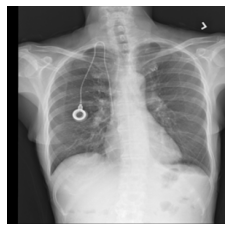

In [9]:
plt.figure()
pic_id = random.randrange(0, samples)
picture = covidData['path'][pic_id]
image = cv2.imread(picture)
plt.imshow(image)
plt.axis('off');
plt.show()  

In [10]:
print('Shape of the image : {}'.format(image.shape))
print('Image Hight {}'.format(image.shape[0]))
print('Image Width {}'.format(image.shape[1]))
print('Dimension of Image {}'.format(image.ndim))
print('Image size {}'.format(image.size))
print('Image Data Type {}'.format(image.dtype))
print('Maximum RGB value in this image {}'.format(image.max()))
print('Minimum RGB value in this image {}'.format(image.min()))

Shape of the image : (299, 299, 3)
Image Hight 299
Image Width 299
Dimension of Image 3
Image size 268203
Image Data Type uint8
Maximum RGB value in this image 254
Minimum RGB value in this image 0


In [11]:
image[0,0]

array([0, 0, 0], dtype=uint8)

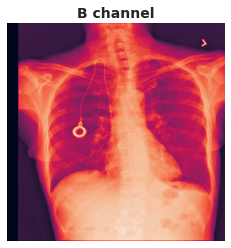

In [12]:
plt.title('B channel',fontsize = 14,weight = 'bold')
plt.imshow(image[ : , : , 0])
plt.axis('off');
plt.show()

In [13]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0,samples):
    mean_val.append(covidData['image'][i].mean())
    std_dev_val.append(np.std(covidData['image'][i]))
    max_val.append(covidData['image'][i].max())
    min_val.append(covidData['image'][i].min())

imageEDA = covidData.loc[:,['image', 'Class','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples

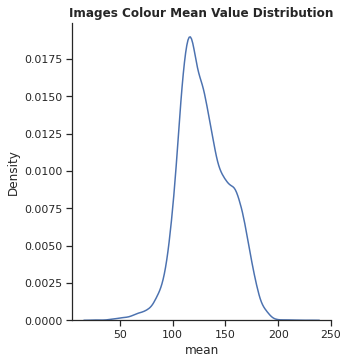

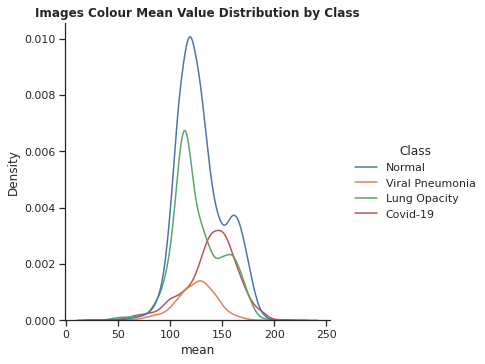

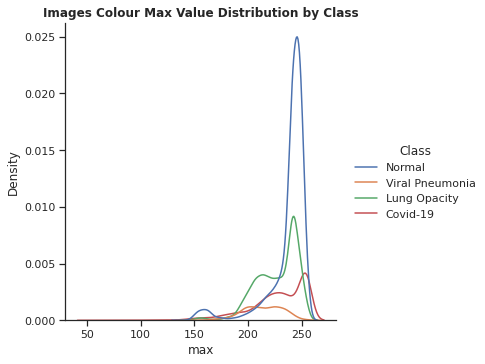

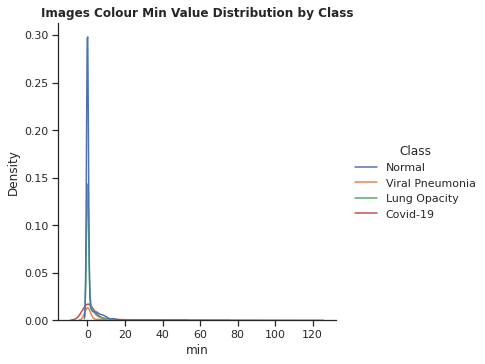

In [14]:
#KDE Plots 

ax = sns.displot(data = imageEDA, x = 'mean', kind="kde");
plt.title('Images Colour Mean Value Distribution', fontsize = 12,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'Class');
plt.title('Images Colour Mean Value Distribution by Class', fontsize = 12,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'Class');
plt.title('Images Colour Max Value Distribution by Class', fontsize = 12,weight = 'bold');
ax = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'Class');
plt.title('Images Colour Min Value Distribution by Class', fontsize = 12,weight = 'bold');

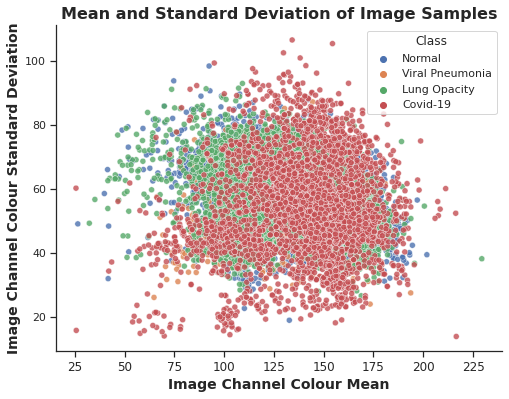

In [15]:
#We analyse the relantionship between an image Mean value and its Standard Deviation.
plt.figure(figsize=(8,6))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=imageEDA, x="mean", y=imageEDA['stedev'], hue = 'Class',alpha=0.8);
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold');

<Figure size 576x432 with 0 Axes>

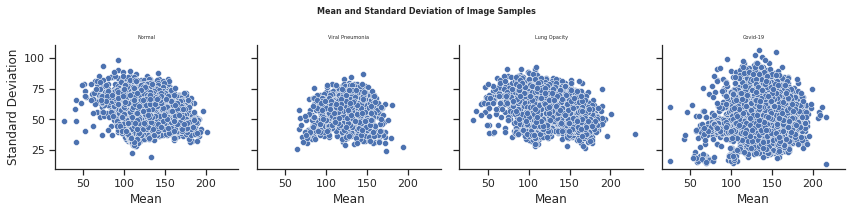

In [16]:
# The Below Graph indicates the Mean and Standard Deviation by each class

plt.figure(figsize=(8,6));
g = sns.FacetGrid(imageEDA, col="Class",height=3);
g.map_dataframe(sns.scatterplot, x='mean', y='stedev');
g.set_titles(col_template="{col_name}", row_template="{row_name}", size = 5)
g.fig.subplots_adjust(top=.5)
g.fig.suptitle('Mean and Standard Deviation of Image Samples',fontsize=8, weight = 'bold')
axes = g.axes.flatten()
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('Mean')
g.fig.tight_layout()

In [17]:
## Building CNN Model

#add the path general where the classes subpath are allocated
path = '/content/COVID-19_Radiography_Dataset'

classes=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
num_classes = len(classes)
batch_size = 16

#Define the parameters to create the training and validation set Images and Data Augmentation parameters
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

#**No Augmentation on the Test set Images**
test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.2)

#loading the images to training set
train_gen = train_datagen.flow_from_directory(directory=path, 
                                              target_size=(224, 224),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")
#loading the images to test set
test_gen = test_datagen.flow_from_directory(directory=path, 
                                              target_size=(224, 224),
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False, classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(224, 224, 1)))
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
#Compile the model
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[Recall()])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 112, 112, 64)     0         
 ooling2D)                                                       
                                                        

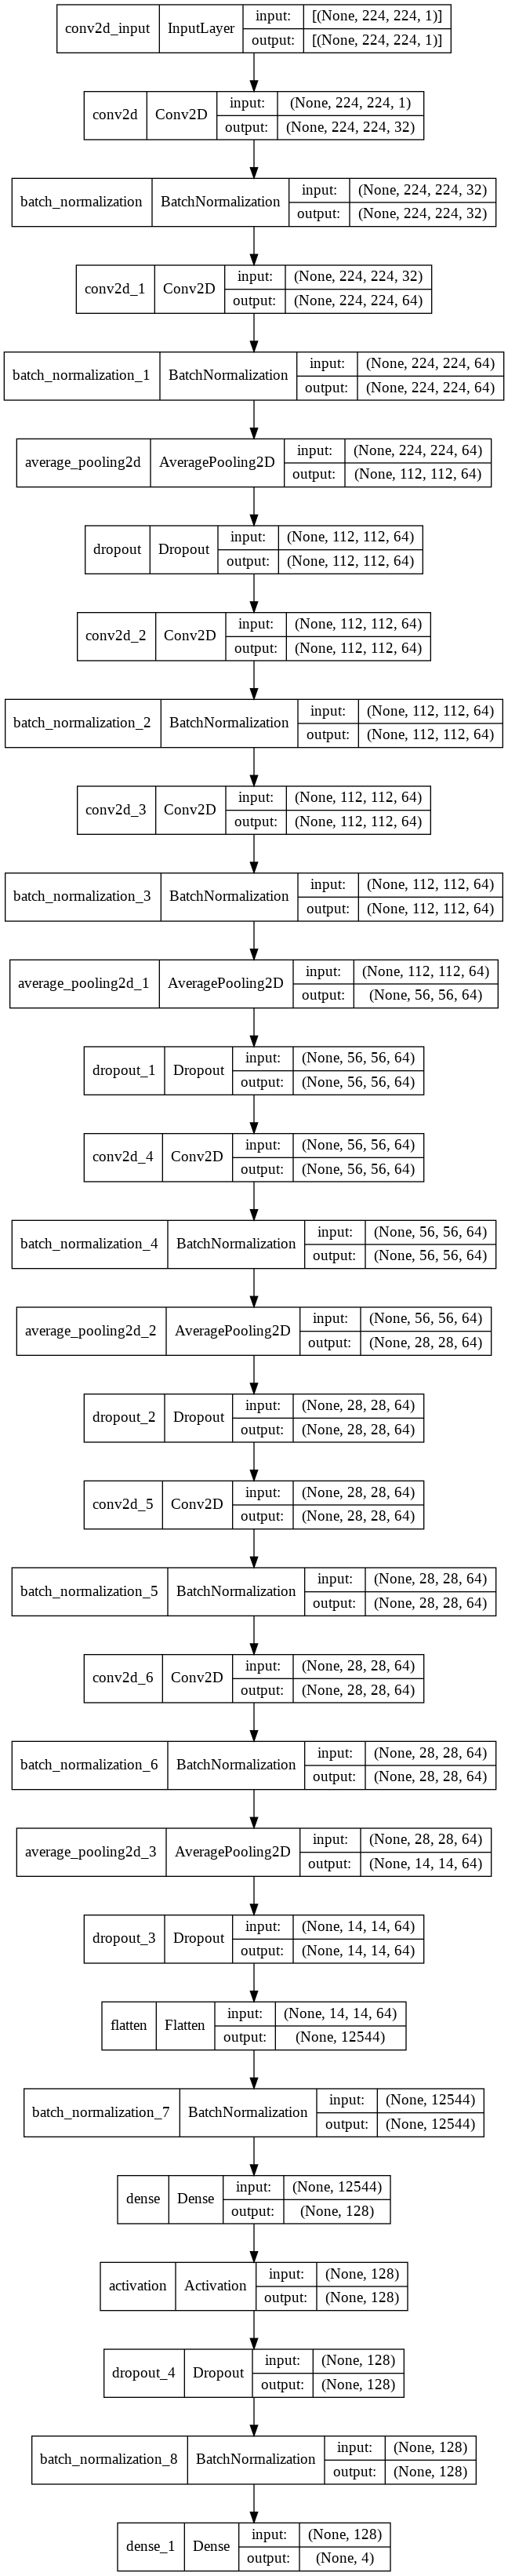

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
from PIL import Image, ImageOps
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size, grayscale=True)
    
    im2 = ImageOps.grayscale(img)
    
    #print(img.shape)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(im2)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            print(str(pred_index))
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    #print(grads)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [22]:
img_array = get_img_array('/content/COVID-19_Radiography_Dataset/COVID/COVID-1000.png', size=(224, 224))
print(img_array.shape)

(1, 224, 224, 1)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [23]:
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_6')

tf.Tensor(3, shape=(), dtype=int64)


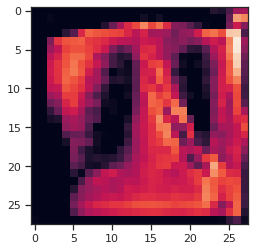

In [24]:
plt.imshow(heatmap)

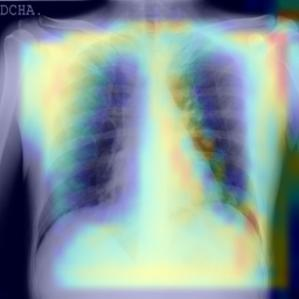

In [25]:
from IPython.display import Image, display
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam('/content/COVID-19_Radiography_Dataset/COVID/COVID-1000.png', heatmap)


In [26]:
#Model Parameters
epochs = 100

#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100,monitor='val_loss', mode = 'min',verbose=0)

callbacks_list = [learning_rate_reduction,early_stopping_monitor]

#Verbose set to 0 to avoid Notebook visual pollution
history = model.fit(train_gen, steps_per_epoch=len(train_gen) // batch_size, 
                                validation_steps=len(test_gen) // batch_size, 
                                validation_data=test_gen, epochs=epochs,callbacks=[callbacks_list],
                                verbose=2)
#Predict Results on test set
y_pred = model.predict(test_gen)

Epoch 1/100
66/66 - 18s - loss: 1.6608 - recall: 0.3835 - val_loss: 0.3832 - val_recall: 0.8711 - lr: 0.0020 - 18s/epoch - 271ms/step
Epoch 2/100
66/66 - 12s - loss: 1.0908 - recall: 0.4460 - val_loss: 0.8024 - val_recall: 0.5586 - lr: 0.0020 - 12s/epoch - 188ms/step
Epoch 3/100
66/66 - 12s - loss: 1.0239 - recall: 0.4811 - val_loss: 0.9978 - val_recall: 0.3008 - lr: 0.0020 - 12s/epoch - 188ms/step
Epoch 4/100
66/66 - 13s - loss: 1.0244 - recall: 0.5024 - val_loss: 0.8481 - val_recall: 0.4961 - lr: 0.0020 - 13s/epoch - 200ms/step
Epoch 5/100
66/66 - 12s - loss: 0.9617 - recall: 0.5199 - val_loss: 0.4625 - val_recall: 0.8516 - lr: 0.0020 - 12s/epoch - 188ms/step
Epoch 6/100
66/66 - 12s - loss: 0.9457 - recall: 0.5085 - val_loss: 1.1218 - val_recall: 0.3555 - lr: 0.0020 - 12s/epoch - 188ms/step
Epoch 7/100
66/66 - 14s - loss: 0.9281 - recall: 0.5407 - val_loss: 1.3534 - val_recall: 0.0938 - lr: 0.0020 - 14s/epoch - 214ms/step
Epoch 8/100
66/66 - 12s - loss: 0.9238 - recall: 0.5369 - val_

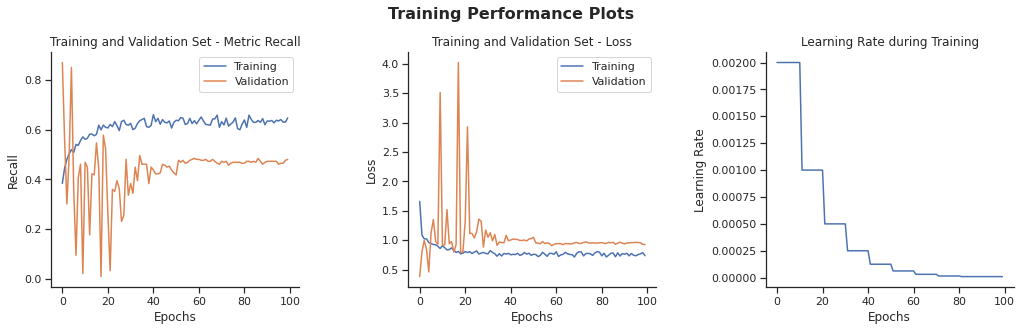

In [27]:
#Plot training and validation Loss
fig, axarr = plt.subplots(1,3, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x =historyDF.index, y = history.history['recall'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_recall'],ax=axarr[0],label="Validation");
ax.set_ylabel('Recall')
ax = sns.lineplot(x =historyDF.index, y = history.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =historyDF.index, y = history.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
ax = sns.lineplot(x =historyDF.index, y = history.history['lr'],ax=axarr[2]);
ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Metric Recall")
axarr[1].set_title("Training and Validation Set - Loss")
axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
plt.suptitle('Training Performance Plots',fontsize=16, weight = 'bold');
fig.tight_layout(pad=3.0)      
plt.show()

In [28]:
import numpy as np

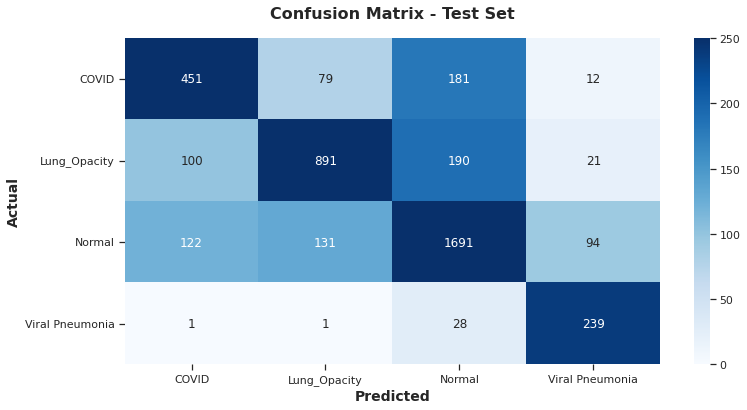

In [29]:
#transform the predictions into array such as [0,0,1,2...]
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
#Retrieve the True classes of the test set
y_true=test_gen.classes
#Build Confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
#ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Green')
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')

ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

In [30]:
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict(test_gen)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(y_pred)
print(test_gen.classes)
print(confusion_matrix(test_gen.classes, y_pred))
print('Classification Report')
target_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
print(classification_report(test_gen.classes, y_pred, target_names=target_names))

[[0.7802166  0.1477851  0.05455764 0.01744071]
 [0.75315326 0.16634583 0.00890516 0.07159574]
 [0.3209992  0.05622298 0.62076384 0.00201402]
 ...
 [0.24713846 0.05091226 0.0188138  0.6831355 ]
 [0.10275752 0.19066054 0.06943158 0.63715035]
 [0.00206385 0.00914638 0.0011148  0.98767495]]
Confusion Matrix
[0 0 2 ... 3 3 3]
[0 0 0 ... 3 3 3]
[[ 451   79  181   12]
 [ 100  891  190   21]
 [ 122  131 1691   94]
 [   1    1   28  239]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.67      0.62      0.65       723
   Lung_Opacity       0.81      0.74      0.77      1202
         Normal       0.81      0.83      0.82      2038
Viral Pneumonia       0.65      0.89      0.75       269

       accuracy                           0.77      4232
      macro avg       0.73      0.77      0.75      4232
   weighted avg       0.78      0.77      0.77      4232



**Overall Results**
Accuracy Result: 77.32%
Precision Result: 73.49%
Recall Result: 77.08%
F-Score Result: 74.78%


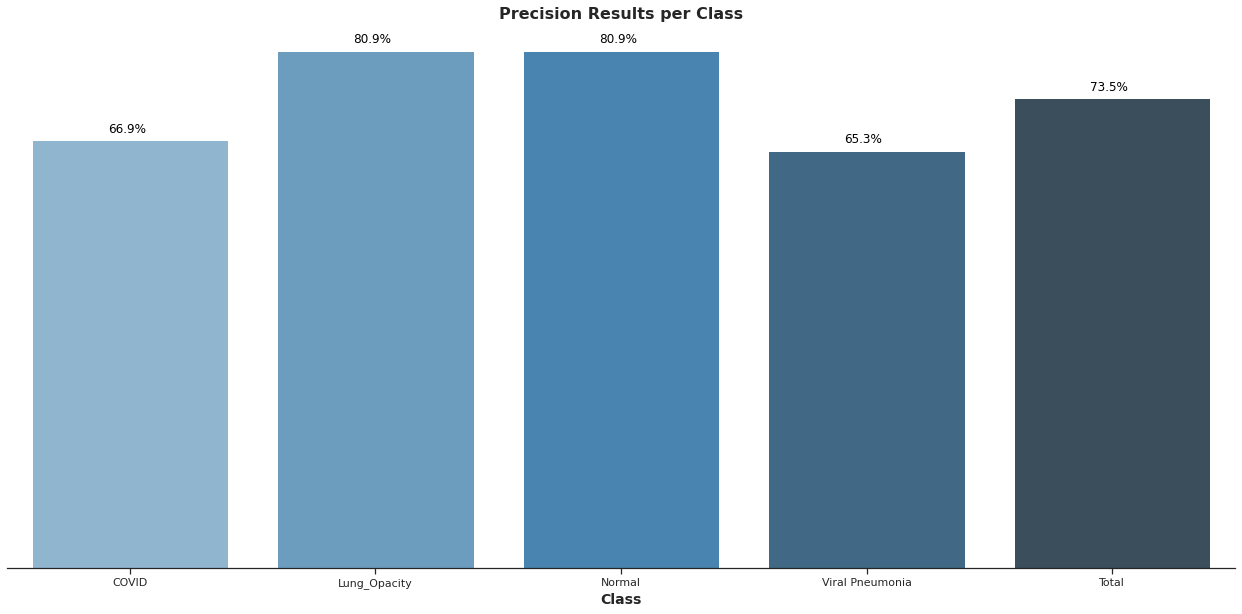

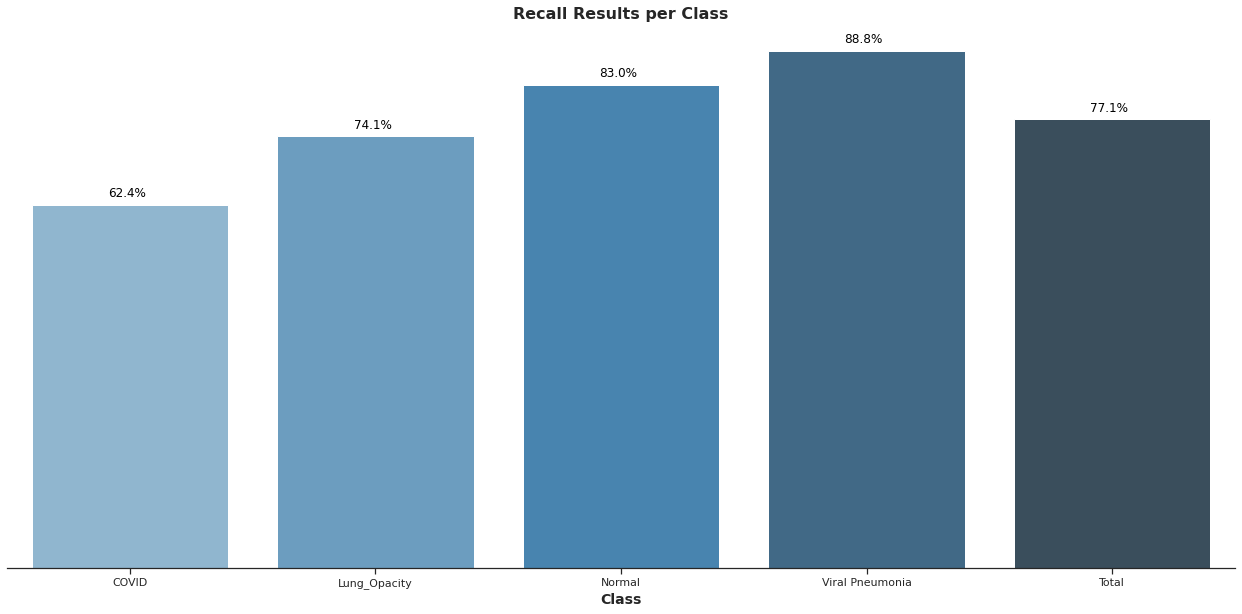

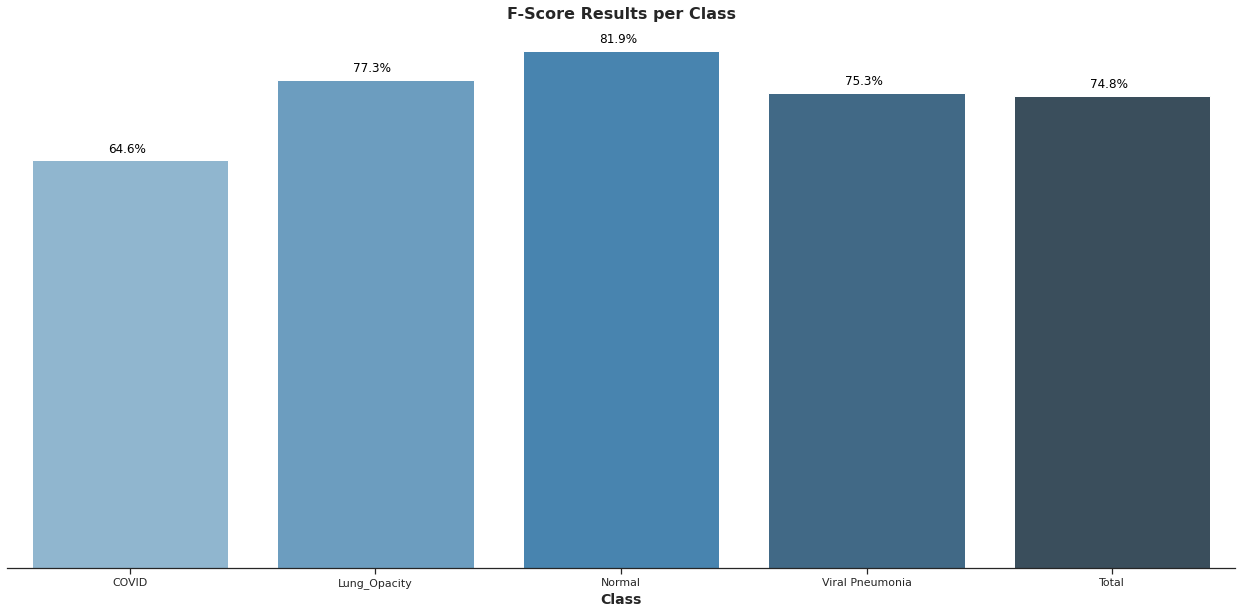

In [31]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))#F-Score of the whole Dataset